In [11]:
import numpy as np
from scipy.sparse import diags
import matplotlib.pyplot as plt
%matplotlib inline

class CrankNicolsonBS:
    def __init__(self, AmEuflag, cpflag, S0, K, T, vol, r, d):
        self.AmEuflag = AmEuflag
        self.cpflag = cpflag
        self.S0 = S0
        self.K = K
        self.T = T
        self.vol = vol
        self.r = r
        self.d = d
        
    def CN_option_info(self, AmEuflag, cpflag, S0, K, T, vol, r, d):
        mu = (r-d-0.5*vol*vol)
        
        # range x in [-x_max, x_max]
        x_max = vol*np.sqrt(T)*5
        
        #number of steps along x
        N = 500
        dx = 2*x_max/N

        # grid along x dimension:
        X = np.linspace(-x_max,x_max,N+1)
        n = np.arange(0,N+1)

        #number of time steps
        J = 500
        dt = T/J
        
        #grid along time dimension:
        Tau = np.arange(J)*dt
        
        # set up the matrix
        a = 0.25*dt*vol*vol/(dx*dx)
        b = 0.25*dt*mu/dx
        c = 0.5*dt*r
        
        A = (1+c+2*a)*np.eye(N+1) + (-a-b)*np.eye(N+1,k=1) + (b-a)*np.eye(N+1,k=-1)
        B = (1-c-2*a)*np.eye(N+1) + (a+b)*np.eye(N+1,k=1) + (a-b)*np.eye(N+1,k=-1)
        Ainv = np.linalg.inv(A)
        
        if cpflag == 'c':
            # Option payoff at maturity
            V = np.clip(S0*np.exp(X)-K,0,1e10)
        elif cpflag == 'p':
            V = np.clip(K-S0*np.exp(X),0,1e10)
        
        cut = int(N/4)

        if AmEuflag == 'Am':
            V0 = V.copy()
            for j in range(J):
                if j == J-1:
                    V1 = V
                V = B.dot(V)
                V = Ainv.dot(V)
                # apply early exercise boundary conditions:
                V = np.where(V>V0, V, V0)
                if j%50==0: plt.plot(S0*np.exp(X[cut:-cut]), V[cut:-cut]) 
                    
        elif AmEuflag == 'Eu':
            for j in range(J):
                if j == J-1:
                    V1 = V
                V = B.dot(V)
                V = Ainv.dot(V)
                V[0] = 0
                V[N] = S0*np.exp(x_max) - K*np.exp(-r*j*dt)
                if j%50==0: plt.plot(S0*np.exp(X[cut:-cut]), V[cut:-cut])
                    
        #mid grid point:
        n_mid = int(N/2)
        price = V[n_mid]
        delta = (V[n_mid+1]-V[n_mid-1])/(S0*np.exp(dx)-S0*np.exp(-dx))
        gamma = ((V[n_mid+1]-V[n_mid])/(S0*(np.exp(dx)-1))-(V[n_mid]-V[n_mid-1])/(S0*(1-np.exp(-dx))))/(S0*np.exp(dx)-S0*np.exp(-dx))*2
        theta = -(V[n_mid]-V1[n_mid])/(dt)
        
        return price, delta, gamma, theta


In [26]:
%run Black_Scholes.ipynb

European Put
Crank-Nicolson
Price: 6.183730512907963 
Delta -0.26289559054661354 
Gamma: 0.009887218380230009 
Theta: -3.631356822542564 

Black-Scholes
Price: 6.183973642681078 
Delta -0.2629205835283911 
Gamma: 0.009885788988853407 
Theta: -3.627550212890475 



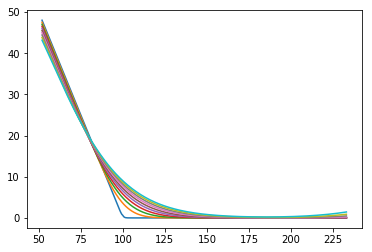

In [37]:
#European Put        
Eu_put = CrankNicolsonBS('Eu', 'p', 110, 100, 1, 0.3, 0.05, 0)
Eu_put_info = Eu_put.CN_option_info('Eu', 'p', 110, 100, 1, 0.3, 0.05, 0)
bs = BS('p',110,100,1,0.05,0,0.3)
bsGreeks = BS_Greeks('p',110,100,1,0.05,0,0.3)
print('European Put\nCrank-Nicolson\nPrice:',Eu_put_info[0],'\nDelta',Eu_put_info[1],'\nGamma:',Eu_put_info[2],'\nTheta:',Eu_put_info[3],'\n')
print('Black-Scholes\nPrice:',bs,'\nDelta',bsGreeks[0],'\nGamma:',bsGreeks[1],'\nTheta:',bsGreeks[2],'\n')


European Call
Price: 3.0392548995928617 
Delta 0.21700633916122186 
Gamma: 0.010175374567780466 
Theta: -0.946274640962752 

Black-Scholes
Price: 3.039505112429424 
Delta 0.25210880467999286 
Gamma: 0.011821924187865495 
Theta: -4.47398916855623 



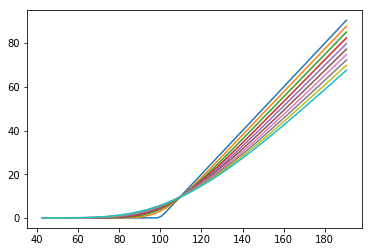

In [39]:
#European Call
Eu_call = CrankNicolsonBS('Eu', 'c', 90, 100, 1, 0.3, 0.01, 0.15)
Eu_call_info = Eu_put.CN_option_info('Eu', 'c', 90, 100, 1, 0.3, 0.01, 0.15)
bs = BS('c',90,100,1,0.01,0.15,0.3)
bsGreeks = BS_Greeks('c',90,100,1,0.01,0.15,0.3)
print('European Call\nPrice:',Eu_call_info[0],'\nDelta',Eu_call_info[1],'\nGamma:',Eu_call_info[2],'\nTheta:',Eu_call_info[3],'\n')
print('Black-Scholes\nPrice:',bs,'\nDelta',bsGreeks[0],'\nGamma:',bsGreeks[1],'\nTheta:',bsGreeks[2],'\n')


American Put
Price: 6.471104428708374 
Delta -0.2796530218382192 
Gamma: 0.010861090889208709 
Theta: -4.054951774444149 



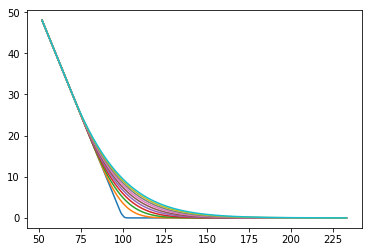

In [4]:
#American Put
Am_put = CrankNicolsonBS('Am', 'p', 110, 100, 1, 0.3, 0.05, 0)
Am_put_info = Am_put.CN_option_info('Am', 'p', 110, 100, 1, 0.3, 0.05, 0)
print('American Put\nPrice:',Am_put_info[0],'\nDelta',Am_put_info[1],'\nGamma:',Am_put_info[2],'\nTheta:',Am_put_info[3],'\n')


American Call
Price: 3.7118601742124526 
Delta 0.28022489333283124 
Gamma: 0.014881018664081785 
Theta: -1.8580917477446501


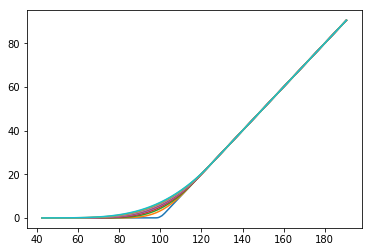

In [5]:
#American Call
Am_call = CrankNicolsonBS('Am', 'c', 90, 100, 1, 0.3, 0.01, 0.15)
Am_call_info = Am_call.CN_option_info('Am', 'c', 90, 100, 1, 0.3, 0.01, 0.15)
print('American Call\nPrice:',Am_call_info[0],'\nDelta',Am_call_info[1],'\nGamma:',Am_call_info[2],'\nTheta:',Am_call_info[3])
